## Notebook : Reference wavelength for atmospheric dispersion correction

In [6]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from moons1d.spectra import SimSpectrum, Template, Spectra , Sky, Atm_abs
from moons1d.simulator import Simulation,airmass_to_zenith_dist, zenith_dist_to_airmass, seeing_to_IQ, Atmospheric_diffraction, Aperture_loss

from astropy import units as u
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
%matplotlib inline 

plt.rcParams['figure.figsize'] = (12,4)

In [7]:
wave = np.arange(0.645,1.8,0.05) * u.micron
sky_aperture = 1.1 * u.arcsec #diam
telescope_diam = 9 * u.m

#Paranal atmospheric conditions
conditions = {}
conditions['temperature']=11.5 * u.deg_C
conditions['humidity']=14.5 * u.percent
conditions['pressure']=743.0 * u.mBa

#Observations parameters
airmass = 1.15 * u.dimensionless_unscaled #30 degrees ZA
seeing =0.8 * u.arcsec

## Spot shift as a function of wavelength and reference wavelength

Due to atmospheric dispersion the light fron an object is dispersed along the north-south axis on sky. This lead to the fibre sampling a marginally different part of the dispersed ligth. This can falsely alter the observed spectral shape of the object.

To minimize the aperture loss in regions of interest, the PI can choose the central wavelength for which atmospheric correction is performed. The plot below shows the shift in arcsec of the spot image in the MOONS bandwith, at airmass of 1.15 and seeing = 0.8", for 3 central wavelengths: 0.8, 1.2, 1.6 microns.

Text(0.5, 0, 'Wavelength [mu]')

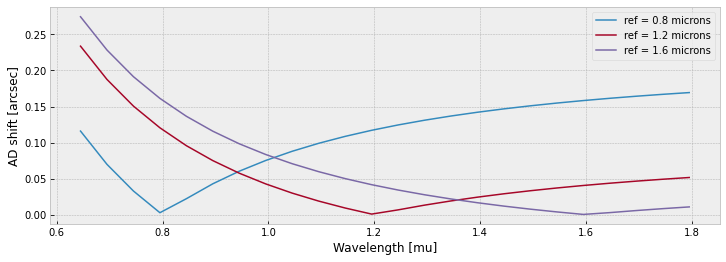

In [9]:
shift_0_8 = Atmospheric_diffraction(wave, airmass, 0.8 * u.micron, conditions)
shift_1_2 = Atmospheric_diffraction(wave, airmass, 1.2 * u.micron, conditions)
shift_1_6 = Atmospheric_diffraction(wave, airmass, 1.6 * u.micron, conditions)

plt.figure(1)
plt.style.use('bmh')
plt.plot(wave, np.abs(shift_0_8),  linewidth=1.5, label= 'ref = 0.8 microns')
plt.plot(wave, np.abs(shift_1_2),  linewidth=1.5, label= 'ref = 1.2 microns')
plt.plot(wave, np.abs(shift_1_6),  linewidth=1.5, label= 'ref = 1.6 microns')
plt.legend(loc='best')
plt.ylabel('AD shift [arcsec]')
plt.xlabel('Wavelength [mu]')

The following plot shows the impact in terms of throughput loss for the same central wavelength. The psf is maintained constant over the full bandwith (seeing=0.8").

Text(0.5, 0, 'Wavelength [mu]')

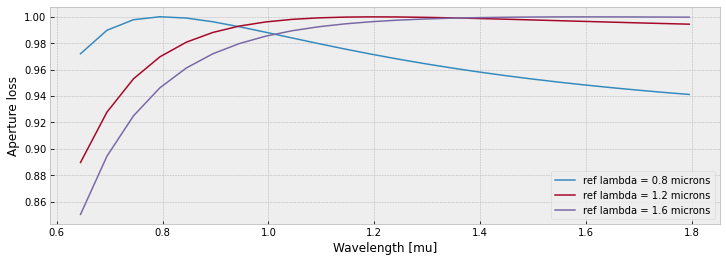

In [10]:
Aper_loss_0_8 = np.zeros(len(shift_0_8))
i=0
for ADisp in shift_0_8: 
    Aper_loss_0_8[i] = Aperture_loss(sky_aperture.value /2., seeing.value, ADisp.value)
    i=i+1
f = interpolate.interp1d(wave, Aper_loss_0_8 )
Aper_loss_0_8/=f(0.8)

Aper_loss_1_2 = np.zeros(len(shift_1_2))
i=0
for ADisp in shift_1_2: 
    Aper_loss_1_2[i] = Aperture_loss(sky_aperture.value /2., seeing.value, ADisp.value)
    i=i+1
f = interpolate.interp1d(wave, Aper_loss_1_2 )
Aper_loss_1_2/=f(1.2)

Aper_loss_1_6 = np.zeros(len(shift_1_6))
i=0
for ADisp in shift_1_6: 
    Aper_loss_1_6[i] = Aperture_loss(sky_aperture.value /2., seeing.value, ADisp.value)
    i=i+1
f = interpolate.interp1d(wave, Aper_loss_1_6 )
Aper_loss_1_6/=f(1.6)


plt.figure(1)
plt.style.use('bmh')
plt.plot(wave, Aper_loss_0_8,  linewidth=1.5, label= 'ref lambda = 0.8 microns')
plt.plot(wave, Aper_loss_1_2,  linewidth=1.5, label= 'ref lambda = 1.2 microns')
plt.plot(wave, Aper_loss_1_6,  linewidth=1.5, label= 'ref lambda = 1.6 microns')

plt.legend(loc='best')
plt.ylabel('Aperture loss')
plt.xlabel('Wavelength [mu]')

## Image quality as a function of wavelength

The function "seeing_to_IQ" computes the image quality (FWHM of the PSF) at a given wavelength for 
    a seeing and airmass value. The fonction uses the equations defined in https://www.eso.org/observing/etc/doc/helpfors.html 
    
The seeing is defined as the image quality at 500nm and airmass=1

Text(0.5, 0, 'Wavelength [mu]')

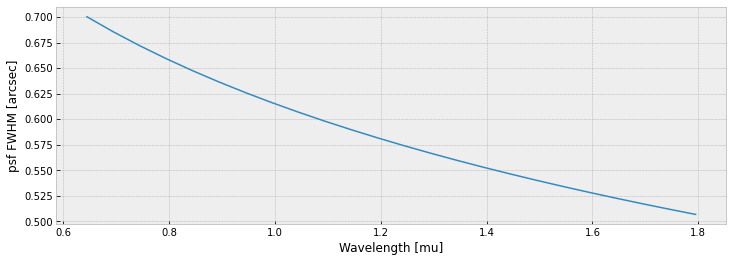

In [11]:
psf = seeing_to_IQ(seeing, wave, airmass, telescope_diam, L_0=46*u.m)

plt.figure(1)
plt.plot(wave, psf,  linewidth=1.5)
plt.ylabel('psf FWHM [arcsec]')
plt.xlabel('Wavelength [mu]')